# Image Segmentation Task 1
#### Welcome to the first task of Image Segmentation. Image segmentation is the process of partitioning the image into a set of pixels representing an object. In this task, you will be introduced to the problem of image segmentation and programming pipeline involved in image segmentation.

For the purpose of this task we will be using PASCAL VOC datset. The dataset contains a total of 2913 images with segmentation annotations. Code in the cell below will download the code and extract the dataset.

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xvf VOCtrainval_11-May-2012.tar

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2012/SegmentationClass/2008_001874.png
VOCdevkit/VOC2012/SegmentationClass/2008_001876.png
VOCdevkit/VOC2012/SegmentationClass/2008_001882.png
VOCdevkit/VOC2012/SegmentationClass/2008_001885.png
VOCdevkit/VOC2012/SegmentationClass/2008_001895.png
VOCdevkit/VOC2012/SegmentationClass/2008_001896.png
VOCdevkit/VOC2012/SegmentationClass/2008_001926.png
VOCdevkit/VOC2012/SegmentationClass/2008_001966.png
VOCdevkit/VOC2012/SegmentationClass/2008_001971.png
VOCdevkit/VOC2012/SegmentationClass/2008_001992.png
VOCdevkit/VOC2012/SegmentationClass/2008_001997.png
VOCdevkit/VOC2012/SegmentationClass/2008_002032.png
VOCdevkit/VOC2012/SegmentationClass/2008_002043.png
VOCdevkit/VOC2012/SegmentationClass/2008_002064.png
VOCdevkit/VOC2012/SegmentationClass/2008_002066.png
VOCdevkit/VOC2012/SegmentationClass/2008_002067.png
VOCdevkit/VOC2012/SegmentationClass/2008_002073.png
VOCdevkit/VOC2012/SegmentationClass/2008_002079.png
VOCdevkit/VOC

### 1.1 Loading the dataset

In [5]:
import os
from os.path import join as pjoin
import collections
import json
import torch
import imageio
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt
import glob
import random
from torchvision.transforms import transforms as tfs
from PIL import Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms
from torch.utils.data import Dataset
import cv2


def read_images(root,train=True):
    if train:
      imgs_file = root + "/ImageSets/Segmentation/train.txt"
    else:
      imgs_file = root + "/ImageSets/Segmentation/val.txt"
    with open(imgs_file,'r') as f:
        images = f.read().split()
    imgs = [os.path.join(root,'JPEGImages', i +'.jpg')for i in images]
    labels = [os.path.join(root,'SegmentationClass', i +'.png')for i in images]
    return imgs,labels

colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,0],[0,64,128]]

color_map_to_label = np.zeros(256**3)
for i , color_map in enumerate(colormap):
    color_map_to_label[(color_map[0]*256+color_map[1])*256+color_map[2]] = i


def transforms(im,label,crop_size):
    h,w,_ = im.shape
    height = crop_size[0]
    width = crop_size[1]
    top = random.randint(0,h-height)
    left = random.randint(0,w-width)
    im = im[top:top+height,left:left+width]
    label = label[top:top+height,left:left+width]
    image_transform=tfs.Compose([
        tfs.ToTensor(),
        tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    im = image_transform(im)
    data = np.array(label,dtype='int32')
    idx = (data[:,:,0]*256+data[:,:,1])*256+data[:,:,2]
    label = np.array(color_map_to_label[idx],dtype='int64')
    label = torch.from_numpy(label)
    return im,label


class pascalVOCDataset(Dataset):
    def __init__(self, root, train, crop_size, transforms):
        self.root = root
        self.crop_size=crop_size
        self.transforms=transforms
        data_list,label_list=read_images(root,train)
        self.data_list=self._filter(data_list)
        self.label_list=self._filter(label_list)
        print('Read'+str(len(self.data_list))+'images')
    def _filter(self,images):
        return [im for im in images if(Image.open(im).size[1] >= self.crop_size[0] and
                                      Image.open(im).size[0] >= self.crop_size[1])]
    def __getitem__(self,idx):
        img = self.data_list[idx]
        label = self.label_list[idx]
        img = cv2.imread(img)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        label = cv2.imread(label)
        label = cv2.cvtColor(label,cv2.COLOR_BGR2RGB)
        img, label=self.transforms(img,label,self.crop_size)
        return img, label
    
    def __len__(self):
        return len(self.data_list)

### 1.2 Define the model architecture(2.0 point)
In this section you have the freedom to decide your own model. Keep in mind though, to perform image segmentation, you need to implement an architecture that does pixel level classification i.e. for each pixel in the image you need to predict the probability of it belonging to one of the 21 categories.

In [ ]:
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
def bilinear_kernel(in_channels,out_channels,kernel_size):
    factor=(kernel_size+1)//2
    if kernel_size%2==1:
        center=factor-1
    else:
        center=factor-0.5
    og=np.ogrid[:kernel_size,:kernel_size]
    filt=(1-abs(og[0]-center)/factor)*(1-abs(og[1]-center)/factor)
    weight=np.zeros((in_channels,out_channels,kernel_size,kernel_size),dtype='float32')
    weight[range(in_channels),range(out_channels),:,:]=filt
    return torch.from_numpy(weight)

pretrained_net=models.resnet34(pretrained=True)
num_classes=21

class fcn(nn.Module):
    def __init__(self, num_classes):
        super(fcn, self).__init__()
        self.stage1 = nn.Sequential(*list(pretrained_net.children())[:-4]) 
        self.stage2 = list(pretrained_net.children())[-4]
        self.stage3 = list(pretrained_net.children())[-3] 
        
        self.scores1 = nn.Conv2d(512, num_classes, 1)
        self.scores2 = nn.Conv2d(256, num_classes, 1)
        self.scores3 = nn.Conv2d(128, num_classes, 1)
        
        self.upsample_8x = nn.ConvTranspose2d(num_classes, num_classes, 16, 8, 4, bias=False)
        self.upsample_8x.weight.data = bilinear_kernel(num_classes, num_classes, 16)
        
        self.upsample_4x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False)
        self.upsample_4x.weight.data = bilinear_kernel(num_classes, num_classes, 4)
        
        self.upsample_2x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False)   
        self.upsample_2x.weight.data = bilinear_kernel(num_classes, num_classes, 4) 

        
    def forward(self, x):
        x = self.stage1(x)
        s1 = x 
        
        x = self.stage2(x)
        s2 = x 
        
        x = self.stage3(x)
        s3 = x 
        
        s3 = self.scores1(s3)
        s3 = self.upsample_2x(s3)
        s2 = self.scores2(s2)
        s2 = s2 + s3
        
        s1 = self.scores3(s1)
        s2 = self.upsample_4x(s2)
        s = s1 + s2

        s = self.upsample_8x(s2)
        return s
    

In [ ]:
# Creating an instance of the model defined above. 
# You can modify it incase you need to pass paratemers to the constructor.
device = torch.device(f'cuda:{0}' if torch.cuda.is_available() else "cpu")
model = fcn(num_classes)
model.to(device)
#net = torch.nn.DataParallel(net, device_ids = [0, 1, 3])
model = torch.nn.DataParallel(model)

### 1.3 Hyperparameters(0.5 points)
Define all the hyperparameters(not restricted to the three given below) that you find useful here.

In [ ]:
local_path = './VOCdevkit/VOC2012/' # modify it according to your device
bs = 32
epochs = 30

### 1.4 Dataset and Dataloader(0.5 points)
Create the dataset using pascalVOCDataset class defined above. Use local_path defined in the cell above as root. 

In [ ]:
from torch.utils.data import DataLoader

input_shape=(320,480)
voc_train=pascalVOCDataset(local_path, True,input_shape,transforms)
voc_test=pascalVOCDataset(local_path, False,input_shape,transforms)
train_data=DataLoader(voc_train,batch_size=bs,shuffle=True)
valid_data=DataLoader(voc_test,batch_size=bs)

Read1114images
Read1078images


### 1.5 Loss fuction and Optimizer(1.0 point)
Define below with the loss function you think would be most suitable for segmentation task. You are free to choose any optimizer to train the network.

In [ ]:
criterion = nn.NLLLoss2d()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-4)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:222: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see https://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "


### 1.6 Training the model(3.0 points)
Your task here is to complete the code below to perform a training loop and save the model weights after each epoch of training.

In [ ]:
import torch.nn.functional as F

train_loss_values = []
val_loss_values = []
train_acc_values = []
val_acc_values = []
PATH = "./model-FCN.cpt"

print("Starting training process..")
for e in range(epochs):
    

    # Training
    train_loss = 0
    model = model.train()
    for data in train_data:
        im = Variable(data[0].to(device))
        label = Variable(data[1].to(device))
        out = model(im)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data

    # Validation
    model = model.eval()
    eval_loss = 0

    for data in valid_data:
        with torch.no_grad():
          im = Variable(data[0].to(device))
          label = Variable(data[1].to(device))
          out = model(im)
          out = F.log_softmax(out, dim=1)
          loss = criterion(out, label)
          eval_loss += loss.data
    # Saving cpt
    print("Saving checkpoint for epoch", e)
    torch.save({
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, PATH+str(e))

    train_loss_values.append( train_loss / len(train_data))
    val_loss_values.append(eval_loss / len(valid_data))

    epoch_str = ('Epoch: {}, Train Loss: {:.5f}, Valid Loss: {:.5f}'.format(
        e, train_loss / len(train_data), eval_loss / len(valid_data)))
   
    print(epoch_str)

Starting training process..
Saving checkpoint for epoch 0
Epoch: 0, Train Loss: 1.34368, Valid Loss: 0.94974
Saving checkpoint for epoch 1
Epoch: 1, Train Loss: 0.83004, Valid Loss: 0.72626
Saving checkpoint for epoch 2
Epoch: 2, Train Loss: 0.66646, Valid Loss: 0.62192
Saving checkpoint for epoch 3
Epoch: 3, Train Loss: 0.57584, Valid Loss: 0.56497
Saving checkpoint for epoch 4
Epoch: 4, Train Loss: 0.50923, Valid Loss: 0.52543
Saving checkpoint for epoch 5
Epoch: 5, Train Loss: 0.46794, Valid Loss: 0.50386
Saving checkpoint for epoch 6
Epoch: 6, Train Loss: 0.43647, Valid Loss: 0.48756
Saving checkpoint for epoch 7
Epoch: 7, Train Loss: 0.41695, Valid Loss: 0.46995
Saving checkpoint for epoch 8
Epoch: 8, Train Loss: 0.39610, Valid Loss: 0.46363
Saving checkpoint for epoch 9
Epoch: 9, Train Loss: 0.37251, Valid Loss: 0.44910
Saving checkpoint for epoch 10
Epoch: 10, Train Loss: 0.36111, Valid Loss: 0.44793
Saving checkpoint for epoch 11
Epoch: 11, Train Loss: 0.34631, Valid Loss: 0.44

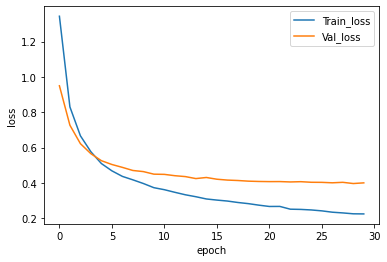

In [ ]:
train_loss_values = torch.FloatTensor(train_loss_values)
val_loss_values = torch.FloatTensor(val_loss_values)

plt.plot(train_loss_values.detach().cpu().numpy())
plt.plot(val_loss_values.detach().cpu().numpy())
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Train_loss", "Val_loss"])
plt.savefig('./loss.png')

In [ ]:
from sklearn.metrics import f1_score,roc_auc_score
import warnings
warnings.filterwarnings("error")

### 1.7 Evaluate your model(1.5 points)
In this section you have to implement the evaluation metrics for your model. Calculate the values of F1-score, dice coefficient and AUC-ROC score on the data you used for training. You can use external packages like scikit-learn to compute above metrics.

In [ ]:
def predict(im, label): 
    evaluated_model.eval()
    cm = np.array(colormap).astype('uint8')
    im = Variable(im.unsqueeze(0)).to(device)
    out = evaluated_model(im)
    pred = out.max(1)[1].squeeze().cpu().data.numpy()
    pred_color = cm[pred]
    return pred_color, pred, cm[label.numpy()]

def onehot_encode(input, num_classes):
  out = []
  for value in input:
    x = [0 for _ in range(num_classes)]
    x[value] = 1
    out.append(x)
  return out

lbls = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

In [ ]:
checkpoint = torch.load("./model-FCN.cpt" + str(29), map_location='cuda')
evaluated_model = fcn(num_classes)
evaluated_model.to(device)
optimizer = torch.optim.SGD(evaluated_model.parameters(), lr=1e-2, weight_decay=1e-4)
evaluated_model = torch.nn.DataParallel(evaluated_model)
evaluated_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
f1 = 0
auc = 0
dice = 0
for k in range(len(voc_train)):
  data, label = voc_train[k]
  pred_color, pred, label_colored = predict(data, label)
  y_true = label.data.cpu().numpy().flatten()
  y_pred = pred.flatten()
  #F1
  f1 += f1_score(y_true, y_pred, average='micro')
  # Perform 1 hot encoding on y_pred
  y_pred_encoded = onehot_encode(y_pred, num_classes)
  #ROC AUC
  try:
    image_auc = (roc_auc_score(y_true,y_pred_encoded, multi_class='ovo', labels=lbls))
    auc += image_auc
  except RuntimeWarning:
     pass
  # Dice (Same as F1, Meaningless)
  I = np.where(y_true==y_pred)
  sum_I = len(I[0])
  sum_U = len(y_true) + len(y_pred) 
  dice += 2*sum_I/sum_U
  # Print progress
  if k % 100 == 0:
    print("Finished {}/{}. F1: {}, auc: {}, dice: {}".format(str(k), str(len(voc_train)), f1/(k+1), auc/(k+1), dice/(k+1)))

print("Done.")
print("=======================================")
print("F1: {}, auc: {}, dice: {}".format(f1/len(voc_train), auc/len(voc_train), dice/len(voc_train)))


Finished 0/1114. F1: 0.95640625, auc: 0.9411081038648095, dice: 0.95640625
Finished 100/1114. F1: 0.9304254331683169, auc: 0.817961551234229, dice: 0.9304254331683169
Finished 200/1114. F1: 0.9314596289386405, auc: 0.8191652495206113, dice: 0.9314596289386405
Finished 300/1114. F1: 0.9331693400470659, auc: 0.8291425456787125, dice: 0.9331693400470659
Finished 400/1114. F1: 0.9345324189526188, auc: 0.8393461770171262, dice: 0.9345324189526188
Finished 500/1114. F1: 0.9369728901571854, auc: 0.8382503727844619, dice: 0.9369728901571854
Finished 600/1114. F1: 0.9376087272081254, auc: 0.8409290241175443, dice: 0.9376087272081254
Finished 700/1114. F1: 0.9360636869204697, auc: 0.8435577995947721, dice: 0.9360636869204697
Finished 800/1114. F1: 0.9351505767530156, auc: 0.8409960324786658, dice: 0.9351505767530156
Finished 900/1114. F1: 0.9341864074639273, auc: 0.8402480085599503, dice: 0.9341864074639273
Finished 1000/1114. F1: 0.9340282764110874, auc: 0.8395266756963221, dice: 0.934028276411

### 1.8 Plot the evaluation metrics against epochs(1.0)
In section 1.6 we saved the weights of the model after each epoch. In this section, you have to calculate the evaluation metrics after each epoch of training by loading the weights for each epoch. Once you have calculated the evaluation metrics for each epoch, plot them against the epochs.

In [7]:
f1_scores = []
for i in range(epochs):
    checkpoint = torch.load("./model-FCN.cpt" + str(i), map_location='cuda')
    evaluated_model = fcn(num_classes)
    evaluated_model.to(device)
    optimizer = torch.optim.SGD(evaluated_model.parameters(), lr=1e-2, weight_decay=1e-4)
    evaluated_model = torch.nn.DataParallel(evaluated_model)
    evaluated_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    f1 = 0
    for k in range(len(voc_train)):
      data, label = voc_train[k]
      pred_color, pred, label_colored = predict(data, label)
      y_true = label.data.cpu().numpy().flatten()
      y_pred = pred.flatten()
      #F1
      f1 += f1_score(y_true, y_pred, average='micro')
    f1_scores.append(f1)
    print("Epoch {}, F1 {}".format(i, f1/len(voc_train)))

Epoch 0, F1 0.7704111030071803
Epoch 1, F1 0.8205127274554901
Epoch 2, F1 0.8461115572168599
Epoch 3, F1 0.8595339266345007
Epoch 4, F1 0.8685941123391685
Epoch 5, F1 0.8746580570204975
Epoch 6, F1 0.8804367823346814
Epoch 7, F1 0.8873394136183422
Epoch 8, F1 0.8929988416834977
Epoch 9, F1 0.8957869889848897
Epoch 10, F1 0.8993456680599201
Epoch 11, F1 0.902040822767055
Epoch 12, F1 0.9053592475968736
Epoch 13, F1 0.9069637146543987
Epoch 14, F1 0.9069728958613865
Epoch 15, F1 0.9123560519991776
Epoch 16, F1 0.9158795023563737
Epoch 17, F1 0.9168479239134489
Epoch 18, F1 0.9190646272815667
Epoch 19, F1 0.9210264951750452
Epoch 20, F1 0.9225176728007193
Epoch 21, F1 0.9235169107196285
Epoch 22, F1 0.9251531467403507
Epoch 23, F1 0.9271439900789201
Epoch 24, F1 0.9277841732589011
Epoch 25, F1 0.9270434175830338
Epoch 26, F1 0.9299044125897667
Epoch 27, F1 0.9319162365350108
Epoch 28, F1 0.931622344404548
Epoch 29, F1 0.9325582664759136


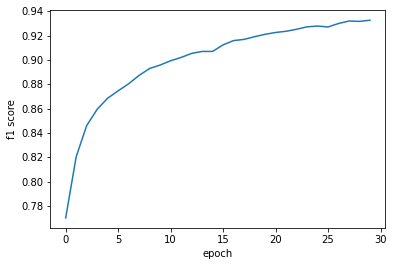

In [8]:
f1_scores = np.array(f1_scores)/len(voc_train)
plt.plot(f1_scores)
plt.xlabel("epoch")
plt.ylabel("f1 score")
plt.savefig('./fi_scores.png')

In [2]:
auc_scores = []
for i in range(0,epochs):
    checkpoint = torch.load("./model-FCN.cpt" + str(i), map_location='cuda')
    evaluated_model = fcn(num_classes)
    evaluated_model.to(device)
    optimizer = torch.optim.SGD(evaluated_model.parameters(), lr=1e-2, weight_decay=1e-4)
    evaluated_model = torch.nn.DataParallel(evaluated_model)
    evaluated_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    auc = 0
    for k in range(len(voc_train)):
      data, label = voc_train[k]
      pred_color, pred, label_colored = predict(data, label)
      y_true = label.data.cpu().numpy().flatten()
      y_pred = pred.flatten()
      # Perform 1 hot encoding on y_pred
      y_pred_encoded = onehot_encode(y_pred, num_classes)
      #ROC AUC
      try:
        image_auc = (roc_auc_score(y_true,y_pred_encoded, multi_class='ovo', labels=lbls))
        auc += image_auc
      except RuntimeWarning:
        pass
    auc_scores.append(auc)
    print("Epoch {}, AUC {}".format(i, auc/len(voc_train)))

Epoch 0, AUC 0.60796848093223
Epoch 1, AUC 0.6720126907459631
Epoch 2, AUC 0.7029369686330514
Epoch 3, AUC 0.7315177768443545
Epoch 4, AUC 0.7798335174672382
Epoch 5, AUC 0.761066358148938
Epoch 6, AUC 0.7799060142129243
Epoch 7, AUC 0.7746646254104683
Epoch 8, AUC 0.7804745925590694
Epoch 9, AUC 0.7826839020913976
Epoch 10, AUC 0.7891548172703973
Epoch 11, AUC 0.7828456884686902
Epoch 12, AUC 0.7976804490092246
Epoch 13, AUC 0.8077094907228428
Epoch 14, AUC 0.8009740644004666
Epoch 15, AUC 0.8193678414996327
Epoch 16, AUC 0.8081827833736112
Epoch 17, AUC 0.8139313788884233
Epoch 18, AUC 0.8123682920617316
Epoch 19, AUC 0.8195310599882809
Epoch 20, AUC 0.8162226105387425
Epoch 21, AUC 0.817367530102039
Epoch 22, AUC 0.8253743318981872
Epoch 23, AUC 0.8222539250088913
Epoch 24, AUC 0.8306426262068188
Epoch 25, AUC 0.8319475953860888
Epoch 26, AUC 0.8304749966921678
Epoch 27, AUC 0.8263301018834016
Epoch 28, AUC 0.8251539709647155
Epoch 29, AUC 0.8162226105387425


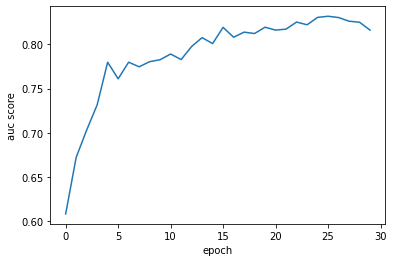

In [6]:
auc_scores = np.array(auc_scores)/len(voc_train)
plt.plot(auc_scores)
plt.xlabel("epoch")
plt.ylabel("auc score")
plt.savefig('./auc_scores.png')

In [1]:
dice_scores = []
for i in range(epochs):
    checkpoint = torch.load("./model-FCN.cpt" + str(i), map_location='cuda')
    evaluated_model = fcn(num_classes)
    evaluated_model.to(device)
    optimizer = torch.optim.SGD(evaluated_model.parameters(), lr=1e-2, weight_decay=1e-4)
    evaluated_model = torch.nn.DataParallel(evaluated_model)
    evaluated_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    dice = 0
    for k in range(len(voc_train)):
      data, label = voc_train[k]
      pred_color, pred, label_colored = predict(data, label)
      y_true = label.data.cpu().numpy().flatten()
      y_pred = pred.flatten()
      # Dice (Same as F1, Meaningless)
      I = np.where(y_true==y_pred)
      sum_I = len(I[0])
      sum_U = len(y_true) + len(y_pred) 
      dice += 2*sum_I/sum_U
    dice_scores.append(dice)
    print("Epoch {}, Dice {}".format(i, dice/len(voc_train)))

Epoch 0, Dice 0.7773814858711094
Epoch 1, Dice 0.8213044210053851
Epoch 2, Dice 0.8435445536916524
Epoch 3, Dice 0.8591798862021249
Epoch 4, Dice 0.8668322206014352
Epoch 5, Dice 0.8758694620549068
Epoch 6, Dice 0.8817383338476221
Epoch 7, Dice 0.8861713490237884
Epoch 8, Dice 0.8911719626627012
Epoch 9, Dice 0.895612920079668
Epoch 10, Dice 0.8997682841019592
Epoch 11, Dice 0.9030776913618341
Epoch 12, Dice 0.9049009879002099
Epoch 13, Dice 0.9082986831893339
Epoch 14, Dice 0.9103813970395725
Epoch 15, Dice 0.9134579254095603
Epoch 16, Dice 0.9143295790320171
Epoch 17, Dice 0.9176329901630765
Epoch 18, Dice 0.9186319358729805
Epoch 19, Dice 0.9204665876533514
Epoch 20, Dice 0.9222972712354123
Epoch 21, Dice 0.9242732878889893
Epoch 22, Dice 0.9257067367033218
Epoch 23, Dice 0.9260096464037237
Epoch 24, Dice 0.9278204656175193
Epoch 25, Dice 0.9287428642560605
Epoch 26, Dice 0.9307545245642573
Epoch 27, Dice 0.9316754504694047
Epoch 28, Dice 0.9322827835128674
Epoch 29, Dice 0.93342573

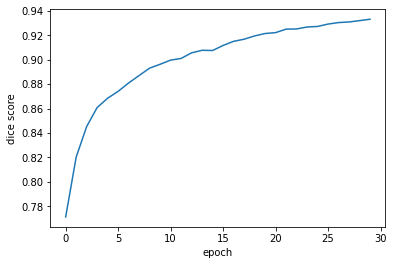

In [ ]:
dice_scores = np.array(dice_scores)/len(voc_train)
plt.plot(dice_scores)
plt.xlabel("epoch")
plt.ylabel("dice score")
plt.savefig('./dice_scores.png')

### 1.9 Visualize results(0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.

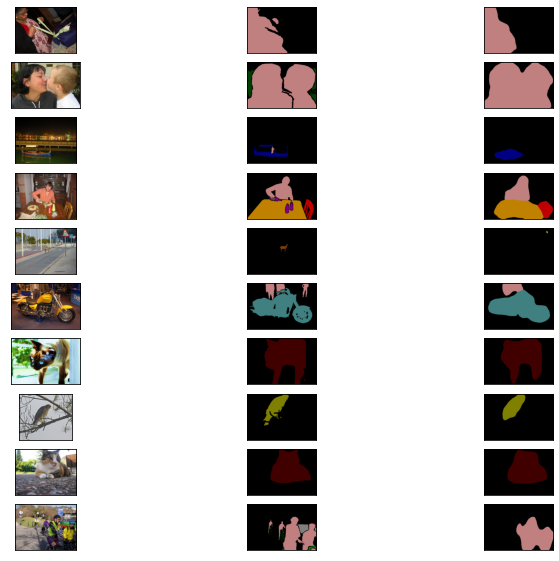

In [ ]:
model.eval()
l, figs = plt.subplots(10, 3, figsize=(12, 10))
for i in range(10):
    x = random.randint(1, 1000)
    test_data, test_label = voc_train[x]
    pred_color, pred, label_color = predict(test_data, test_label)
    figs[i, 0].imshow(Image.open(voc_train.data_list[x]))
    figs[i, 0].axes.get_xaxis().set_visible(False)
    figs[i, 0].axes.get_yaxis().set_visible(False)
    figs[i, 1].imshow(label_color)
    figs[i, 1].axes.get_xaxis().set_visible(False)
    figs[i, 1].axes.get_yaxis().set_visible(False)
    figs[i, 2].imshow(pred_color)
    figs[i, 2].axes.get_xaxis().set_visible(False)
    figs[i, 2].axes.get_yaxis().set_visible(False)
l.savefig('full_figure.png')